# Predicting stock prices

This is a walkthrough of the whole pipeline to predict stock price of a publicly listed company using deep learning.
The model uses the historical stock data of a company and predicts the sotck price for the next 20 days.
This forecasting model can be used to extrapolate thge stock prices for future leveraging the historical information.

Here is an overview of the contents of the notebook - 

* [Importing important libraries](#import)
* [Extracting the Data](#data)
* [Data Preparation](#prepare)
* [Model and Parameters](#model)
* [Visualize the train data predictions and loss](#trainplots)

### Importing important libraries <a class="anchor" id="import"></a>

In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import time

# to ignore any warnings
import warnings
warnings.filterwarnings("ignore")

### Data <a class="anchor" id="data"></a>

In [2]:
# declaring the start and end dates

start_date = '2010-01-01'
end_date = '2022-05-31'
company_ticker_symbol = 'GOOGL'

panel_data = data.DataReader(
    company_ticker_symbol, 'yahoo', start_date, end_date)
panel_data = panel_data.reset_index()

In [3]:
# For this problem, we will be working with the closing prices on the stock market for the company

price = panel_data[['Close']]
price.head()

,Close
0,313.688690
1,312.307312
2,304.434448
3,297.347351
4,301.311310


In [4]:
print('The data has', price.shape[0], 'records.')

The data has 3124 records.


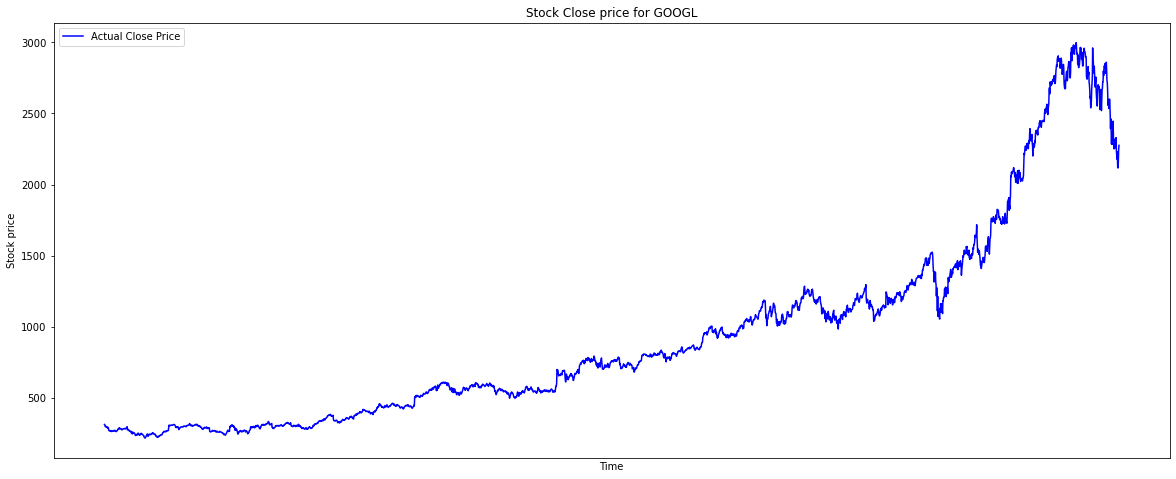

In [5]:
# Plot
data = price['Close']
plt.figure(figsize=(20, 8))
plt.plot(data, color='blue', label='Actual Close Price')
plt.title(f'Stock Close price for {company_ticker_symbol}')
plt.ylabel('Stock price')
plt.xlabel('Time')
plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

plt.legend()
plt.show()

### Data Preparation <a class="anchor" id="prepare"></a>

In [6]:
# We scale the data using MinMaxScaler imported from the sklearn library

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price[['Close']])

In [7]:
# split training and validation sets manually
# We cannot use the train test split from sklearn as we need sequential data for time based information.
# This funciton splits the data by taking into account the lookback period defined. For a lookback period of n days,
# the sequence has data of (n-1) days to predict the price of the nth day.


def split_data(stock, lookback, val_size):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(val_size*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

1844 data sequences of length 21 each where the last value is the prediction

In [8]:
lookback = 31
val_size = 0.2
x_train, y_train, x_val, y_val = split_data(price, lookback, val_size)
print('Shape of X train', x_train.shape)
print('Shape of y train', y_train.shape)
print('Shape of X val', x_val.shape)
print('Shape of y val', y_val.shape)

Shape of X train (2474, 30, 1)
Shape of y train (2474, 1)
Shape of X val (619, 30, 1)
Shape of y val (619, 1)


In [9]:
# converting the data to torch tensors

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

### Defining the model and parameters <a class="anchor" id="model"></a>

In [10]:
# defining the hyperparameters for the model

input_dim = 1
hidden_dim = 20
num_layers = 3
output_dim = 1
num_epochs = 500
learning_rate = 0.01

In [11]:
# Defining the model
# This model uses LSTM layers

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [12]:
# Declaring the model and defining the loss function and optimizer
# Here we have used MSELoss as the loss function and Adam Optimizer
# We use Mean squared error loss because our predictions are continuous values

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim,
             output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
losses_train = np.zeros(num_epochs)
losses_val = np.zeros(num_epochs)

start_time = time.time()

# The training loop


def train(x_train, y_train, x_val, y_val):
    for t in range(num_epochs):
        print("Epoch", t)
        model.train()

        y_train_pred = model(x_train)

        train_loss = criterion(y_train, y_train_pred)
        print("MSE on train data: ", train_loss.item())
        losses_train[t] = train_loss.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        model.eval()

        y_val_pred = model(x_val)
        val_loss = criterion(y_val, y_val_pred)
        print("MSE on val data: ", val_loss.item())
        losses_val[t] = val_loss.item()

    return y_train_pred, y_val_pred


y_train_pred, y_val_pred = train(x_train, y_train, x_val, y_val)
training_time = time.time() - start_time

print("Training time: {}".format(training_time))

Epoch 0
MSE on train data:  0.8040096163749695
MSE on val data:  0.25184211134910583
Epoch 1
MSE on train data:  0.6114177107810974
MSE on val data:  0.3227177560329437
Epoch 2
MSE on train data:  0.4575381875038147
MSE on val data:  0.439068466424942
Epoch 3
MSE on train data:  0.3027117848396301
MSE on val data:  0.6590766310691833
Epoch 4
MSE on train data:  0.145610049366951
MSE on val data:  1.09598708152771
Epoch 5
MSE on train data:  0.05272318050265312
MSE on val data:  1.7676268815994263
Epoch 6
MSE on train data:  0.13268843293190002
MSE on val data:  1.7818078994750977
Epoch 7
MSE on train data:  0.13177399337291718
MSE on val data:  1.5702630281448364
Epoch 8
MSE on train data:  0.08817450702190399
MSE on val data:  1.3432238101959229
Epoch 9
MSE on train data:  0.059841182082891464
MSE on val data:  1.1669694185256958
Epoch 10
MSE on train data:  0.05380754917860031
MSE on val data:  1.0476436614990234
Epoch 11
MSE on train data:  0.05964222177863121
MSE on val data:  0.97

MSE on val data:  0.6601595282554626
Epoch 96
MSE on train data:  0.016634130850434303
MSE on val data:  0.6438875198364258
Epoch 97
MSE on train data:  0.01684180274605751
MSE on val data:  0.6309539079666138
Epoch 98
MSE on train data:  0.016954408958554268
MSE on val data:  0.6216625571250916
Epoch 99
MSE on train data:  0.017023425549268723
MSE on val data:  0.6159362196922302
Epoch 100
MSE on train data:  0.017095856368541718
MSE on val data:  0.6133536696434021
Epoch 101
MSE on train data:  0.017634714022278786
MSE on val data:  0.6130170226097107
Epoch 102
MSE on train data:  0.01679997891187668
MSE on val data:  0.6148797869682312
Epoch 103
MSE on train data:  0.016728857532143593
MSE on val data:  0.6182934045791626
Epoch 104
MSE on train data:  0.016640082001686096
MSE on val data:  0.6226292848587036
Epoch 105
MSE on train data:  0.01661832071840763
MSE on val data:  0.6273074746131897
Epoch 106
MSE on train data:  0.016572481021285057
MSE on val data:  0.6318866014480591
Ep

MSE on val data:  0.5764193534851074
Epoch 190
MSE on train data:  0.002184940269216895
MSE on val data:  0.580507218837738
Epoch 191
MSE on train data:  0.00165820331312716
MSE on val data:  0.5854998230934143
Epoch 192
MSE on train data:  0.0019125643884763122
MSE on val data:  0.5898641347885132
Epoch 193
MSE on train data:  0.002038792474195361
MSE on val data:  0.5931158065795898
Epoch 194
MSE on train data:  0.0016425246139988303
MSE on val data:  0.5958536863327026
Epoch 195
MSE on train data:  0.0014077912783250213
MSE on val data:  0.5992875099182129
Epoch 196
MSE on train data:  0.0016098503256216645
MSE on val data:  0.6042469143867493
Epoch 197
MSE on train data:  0.0015119658783078194
MSE on val data:  0.6104151606559753
Epoch 198
MSE on train data:  0.0012359034735709429
MSE on val data:  0.6166004538536072
Epoch 199
MSE on train data:  0.001246482366696
MSE on val data:  0.6216112375259399
Epoch 200
MSE on train data:  0.001337424386292696
MSE on val data:  0.62482994794

MSE on val data:  0.5226141810417175
Epoch 283
MSE on train data:  0.0002970885834656656
MSE on val data:  0.5213481783866882
Epoch 284
MSE on train data:  0.0002942144055850804
MSE on val data:  0.5201079845428467
Epoch 285
MSE on train data:  0.00029152221395634115
MSE on val data:  0.5189139246940613
Epoch 286
MSE on train data:  0.0002893382334150374
MSE on val data:  0.517788827419281
Epoch 287
MSE on train data:  0.0002871126343961805
MSE on val data:  0.5167251825332642
Epoch 288
MSE on train data:  0.00028456078143790364
MSE on val data:  0.5156934857368469
Epoch 289
MSE on train data:  0.00028191565070301294
MSE on val data:  0.5146772265434265
Epoch 290
MSE on train data:  0.000279365194728598
MSE on val data:  0.5136856436729431
Epoch 291
MSE on train data:  0.00027712626615539193
MSE on val data:  0.5127274394035339
Epoch 292
MSE on train data:  0.0002748919650912285
MSE on val data:  0.5117887258529663
Epoch 293
MSE on train data:  0.00027275297907181084
MSE on val data:  

MSE on val data:  0.4794258773326874
Epoch 375
MSE on train data:  0.0002215004788013175
MSE on val data:  0.479336142539978
Epoch 376
MSE on train data:  0.00022124288079794496
MSE on val data:  0.47924840450286865
Epoch 377
MSE on train data:  0.00022098759654909372
MSE on val data:  0.47916269302368164
Epoch 378
MSE on train data:  0.00022073445143178105
MSE on val data:  0.47907859086990356
Epoch 379
MSE on train data:  0.0002204834163421765
MSE on val data:  0.4789959192276001
Epoch 380
MSE on train data:  0.00022023449128028005
MSE on val data:  0.4789148271083832
Epoch 381
MSE on train data:  0.00021998758893460035
MSE on val data:  0.4788352847099304
Epoch 382
MSE on train data:  0.0002197426656493917
MSE on val data:  0.4787568151950836
Epoch 383
MSE on train data:  0.00021949964866507798
MSE on val data:  0.47867950797080994
Epoch 384
MSE on train data:  0.0002192585525335744
MSE on val data:  0.47860339283943176
Epoch 385
MSE on train data:  0.00021901917352806777
MSE on val

MSE on val data:  0.474118173122406
Epoch 467
MSE on train data:  0.00020326253434177488
MSE on val data:  0.4740738272666931
Epoch 468
MSE on train data:  0.00020310231775511056
MSE on val data:  0.47402963042259216
Epoch 469
MSE on train data:  0.00020294261048547924
MSE on val data:  0.47398561239242554
Epoch 470
MSE on train data:  0.00020278349984437227
MSE on val data:  0.4739416241645813
Epoch 471
MSE on train data:  0.0002026248985202983
MSE on val data:  0.4738978445529938
Epoch 472
MSE on train data:  0.00020246683561708778
MSE on val data:  0.4738541841506958
Epoch 473
MSE on train data:  0.00020230934023857117
MSE on val data:  0.4738106429576874
Epoch 474
MSE on train data:  0.000202152383280918
MSE on val data:  0.4737672507762909
Epoch 475
MSE on train data:  0.0002019958628807217
MSE on val data:  0.47372397780418396
Epoch 476
MSE on train data:  0.00020183989545330405
MSE on val data:  0.4736808240413666
Epoch 477
MSE on train data:  0.00020168451010249555
MSE on val d

In [14]:
# Let's compare the predicted values and the true values

actuals = sum(scaler.inverse_transform(y_train.detach().numpy()).tolist(), [])
preds = sum(scaler.inverse_transform(
    y_train_pred.detach().numpy()).tolist(), [])
y_val = sum(scaler.inverse_transform(y_val.detach().numpy()).tolist(), [])
y_val_pred = sum(scaler.inverse_transform(
    y_val_pred.detach().numpy()).tolist(), [])
result_df = pd.DataFrame([actuals, preds]).T.rename(
    columns={0: "Actual_price", 1: "Predicted_price"})
result_df.head(10)

,Actual_price,Predicted_price
0,269.374359,272.417236
1,271.881897,272.171783
2,270.650635,272.185364
3,271.671631,272.160370
4,267.802765,272.250366
5,266.000977,272.048981
6,263.478455,271.698486
7,263.663696,271.134155
8,266.611603,270.571472
9,270.800781,270.241760


### Visualizing the results on train data and validation data  <a class="anchor" id="trainplots"></a>

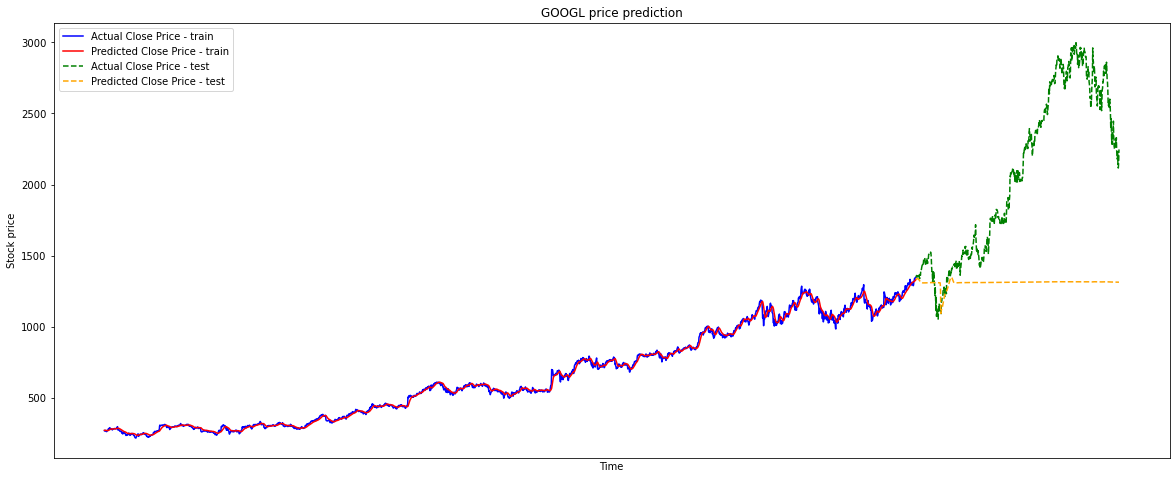

In [17]:
# Plot all predictions on train data

plt.figure(figsize=(20, 8))
plt.plot(result_df['Actual_price'], color='blue',
         label='Actual Close Price - train')
plt.plot(result_df['Predicted_price'], color='red',
         label='Predicted Close Price - train')
plt.plot(np.arange(2474, 3093), pd.Series(y_val), color='green',
         label='Actual Close Price - test', linestyle='dashed')
plt.plot(np.arange(2474, 3093), pd.Series(y_val_pred), color='orange',
         label='Predicted Close Price - test', linestyle='dashed')
plt.title(f'{company_ticker_symbol} price prediction')
plt.ylabel('Stock price')
plt.xlabel('Time')
plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

plt.legend()
plt.show()

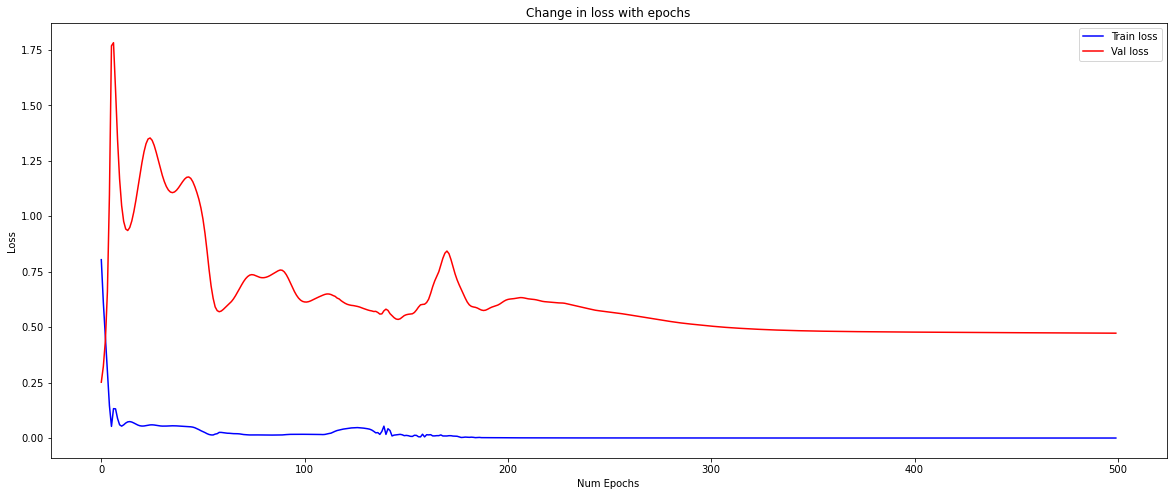

In [18]:
# Plot the Loss

plt.figure(figsize=(20, 8))
plt.plot(losses_train, color='blue', label='Train loss')
plt.plot(losses_val, color='red', label='Val loss')
plt.title('Change in loss with epochs')
plt.ylabel('Loss')
plt.xlabel('Num Epochs')


plt.legend()
plt.show()